## BE485, Lab 11, Ex 2
 In this exercise:<br>
 a) Read multiple daily surface reflectance files<br>
 b) Compute daily vegetation indices<br>
 c) Apply the VI compositing algorithm<br>
 d) Save a HDF file
  

In [1]:
# Import all necessary libraries

import os
import matplotlib.pyplot as plt
import numpy as np

# Library for reading HDF files
from pyhdf.SD import SD, SDC


#Import the VIP Library
import viplab_lib5 as vip

# This is a magic function call that renders the figure in a notebook
# instead of displaying a dump of the figure object
%matplotlib inline


# user defined functions

In [2]:
#user defined functions

#custom function to read RED, NIR, VZA and RANK from HDF file
#and calculate NDVI
def HDFread_VIS_Calc(filename,FILL_VI=-13000):
    print("Reading ",filename)
    hdf = SD(filename, SDC.READ)
    
    sdsRED= hdf.select('RED')
    bandRED=sdsRED.get()
    
    sdsNIR= hdf.select('NIR')
    bandNIR=sdsNIR.get()
    
    sdsVZA= hdf.select('VZA')
    bandVZA=sdsVZA.get()
    
    sdsRANK= hdf.select('RankMODIS')
    bandRANK=sdsRANK.get()
    
    hdf.end()
    print("Computing.. NDVI")
    
    nrows,ncols=bandRED.shape
    #define NDVI band
    bandNDVI=np.zeros((nrows,ncols),np.int16)
    #bandRANK=np.zeros((nrows,ncols),np.int8)
    
    for i in range(0,nrows):
      for j in range(0,ncols):
         red=bandRED[i,j]/10000
         NIR=bandNIR[i,j]/10000
       
         if(red>0 and red<1 and NIR>0 and NIR<1):
            bandNDVI[i,j]=vip.calc_NDVI(red,NIR,FILL_VI)
         else:
            bandNDVI[i,j]=FILL_VI
         
    return bandNDVI,bandVZA,bandRANK 

# get composited from a list of values
def getComposited(NDVIList, VZAList, RANKList, RANKFilter):
    index=-1

    NDVImax=-10000
    IndexNDVImax=-1
    # theshold of 35deg
    VZAThreshold=3500
    NDVImaxVZ=-10000
    IndexNDVI_VZ=-1
      
    for d in range(0,16):
       RANK=RANKList[d]
       if(RANK in RANKFilter):
           NDVI=NDVIList[d]
           VZA=VZAList[d]
           if(NDVI>NDVImax):
              NDVImax=NDVI
              IndexNDVImax=d
           if(VZA<=VZAThreshold and NDVI>-10000):
               if(NDVI>NDVImaxVZ):
                   NDVImaxVZ=NDVI
                   IndexNDVI_VZ=d

              
    if(IndexNDVI_VZ>-1):
        #favor max NDVI with VZA bin:CV_ MVC
        index=IndexNDVI_VZ
    else:
        #use MVC
        index=IndexNDVImax

    return index 


## Main program starts here !
## * Read each file and compute NDVI

In [3]:
#
nrows=1200
ncols=1200
FILL_VI=-13000

# MODIS RANK categories
RANK_GOOD=0
RANK_MARGINAL=1
RANK_SNOWICE=2
RANK_CLOUDY=3

print("Reading 16 days of data and computing VIS, it will take a few minutes (~5mins) ...")
startTime=vip.startTime()

#create band arrays to store 16 daily images
NDVIDaily=np.zeros((nrows,ncols,16),np.int16)
VZADaily=np.zeros((nrows,ncols,16),np.int16)
RANKDaily=np.zeros((nrows,ncols,16),np.int8)     
QADaily=np.zeros((nrows,ncols,16),np.uint16)

#data path

datapath="./data_daily/"

#list of days 
DOYList=['065','066','067','068','069','070','071','072','073','074',
         '075','076','077','078','079','080']
#loop 16 days
for i in range(0,16):
    DOY=DOYList[i]
    #create filename
    filename=datapath+'MOD09GA.A2020'+DOY+'.h08v05.006.hdf'
    #read HDF bands and compute NDVI
    NDVI,VZA,RANK=HDFread_VIS_Calc(filename)
    #store in daily array
    NDVIDaily[:,:,i]=NDVI
    VZADaily[:,:,i]=VZA
    RANKDaily[:,:,i]=RANK
    
vip.endTime(startTime)    


Reading 16 days of data and computing VIS, it will take a few minutes (~5mins) ...
Reading  ./data_daily/MOD09GA.A2020065.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020066.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020067.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020068.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020069.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020070.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020071.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020072.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020073.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020074.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020075.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020076.h08v05.006.hdf
Computing.. NDVI
Reading  ./data_daily/MOD09GA.A2020077.h08v05.006.hdf
Computing..

## * Run Compositing algorithm

In [4]:

print("Running VI Compositing algorithm... wait another few minutes")
startTime=vip.startTime()

#Create datasets to store the composited values
bandNDVI_compo=np.zeros((nrows,ncols),np.int16)
bandRANK_compo=np.zeros((nrows,ncols),np.int8)
bandVZA_compo=np.zeros((nrows,ncols),np.int16)
bandCDAY=np.zeros((nrows,ncols),np.int16)

    
#perform compositing for each pixel
for i in range(0,nrows):
  for j in range(0,ncols):
      #get vector through time (same pixel, 16days)
      NDVIList=NDVIDaily[i,j,:]
      RANKList=RANKDaily[i,j,:]
      VZAList=VZADaily[i,j,:]
      
      #check if there is any pixel with highest quality
      if RANK_GOOD in RANKList:
          index=getComposited(NDVIList, VZAList, RANKList, [RANK_GOOD])
      elif RANK_MARGINAL in RANKList:
          index=getComposited(NDVIList, VZAList, RANKList, [RANK_GOOD,RANK_MARGINAL])
      elif RANK_SNOWICE in RANKList:
          index=getComposited(NDVIList, VZAList, RANKList, [RANK_GOOD,RANK_MARGINAL,RANK_SNOWICE])
      else:
          index=getComposited(NDVIList, VZAList, RANKList, [RANK_GOOD,RANK_MARGINAL,RANK_SNOWICE,RANK_CLOUDY])
      
      if(index>=0):
          #a day was found    
         NDVI=NDVIList[index]
         RANK=RANKList[index]
         VZA=VZAList[index]
         CDAY=index+65
      else:
          #no valid data. set fill values
          NDVI=FILL_VI
          RANK=-1
          VZA=-18000
          CDAY=-1
          
      bandNDVI_compo[i,j]=NDVI
      bandRANK_compo[i,j]=RANK
      bandVZA_compo[i,j]=VZA
      bandCDAY[i,j]=CDAY
     
vip.endTime(startTime,"Compositing completed: ")


Running VI Compositing algorithm... wait another few minutes
Compositing completed:  1.0  min  13.942663908004755  sec


## * Extract some pixels to understand the compositing
* Markers from here https://www.pythonpool.com/matplotlib-marker/

Plotting daily data for 2 selected pixels
Compositing Example:
 DAY, NDVI, VZA , RANK
1 , 1653 , 2199 , 1
2 , 1900 , 6062 , 1
3 , 860 , 192 , 3
4 , 2404 , 5842 , 0
5 , 1757 , 2528 , 1
6 , 37 , 4766 , 3
7 , 745 , 4329 , 3
8 , -171 , 3198 , 3
9 , 347 , 5588 , 3
10 , 1023 , 1036 , 3
11 , 2857 , 6252 , 3
12 , 535 , 1423 , 3
13 , 1641 , 5348 , 3
14 , 188 , 3524 , 3
15 , 751 , 4041 , 3
16 , 989 , 5025 , 3
Composited: day= 68 , NDVI= 2404


<Figure size 432x288 with 0 Axes>

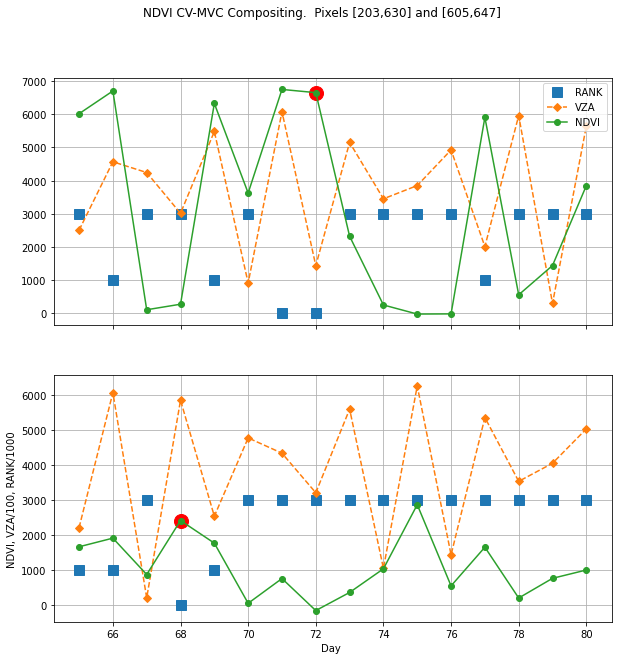

In [14]:
print("Plotting daily data for 2 selected pixels")
#display compositing values for pixel at row=203, col=630
row=203
col=630
X=np.linspace(65,80,num=16)
NDVIList=NDVIDaily[row,col,:]
RANKList=RANKDaily[row,col,:]
VZAList=VZADaily[row,col,:]
NDVIC=bandNDVI_compo[row,col]
DAYC=bandCDAY[row,col]


plt.figure(1)
f, plot = plt.subplots(nrows=2,sharex=True,figsize=(10,10))
plt.suptitle('NDVI CV-MVC Compositing.  Pixels [203,630] and [605,647] ')
plot[0].plot(X,RANKList*1000,'s',markersize=10, label='RANK')
plot[0].plot(X,VZAList,linestyle='--', marker='D', label='VZA')
plot[0].plot([DAYC],[NDVIC],marker='o', color='r', markersize=14)
plot[0].plot(X,NDVIList,linestyle='-', marker='o',label='NDVI')
plot[0].grid(True)
plot[0].legend(loc='upper right')
#plot[0].xlabel('Day of the Year')

row=605
col=647
NDVIList=NDVIDaily[row,col,:]
RANKList=RANKDaily[row,col,:]
VZAList=VZADaily[row,col,:]
NDVIC=bandNDVI_compo[row,col]
DAYC=bandCDAY[row,col]
plot[1].plot(X,RANKList*1000,'s',markersize=10,label='RANK')
plot[1].plot(X,VZAList,linestyle='--', marker='D',label='VZA')
plot[1].plot([DAYC],[NDVIC],marker='o', color='r', markersize=14)
plot[1].plot(X,NDVIList,linestyle='-', marker='o',label='NDVI')
plot[1].grid(True)
plot[1].set(xlabel='Day ')
plot[1].set(ylabel='NDVI, VZA/100, RANK/1000') 

print('Compositing Example:')
print(' DAY, NDVI, VZA , RANK')
for i in range(0,16):
    print((i+1),',', NDVIList[i],',',VZAList[i],',',RANKList[i])
print('Composited: day=',DAYC, ', NDVI=',NDVIC)    

### * Plot Composited datasets

Plotting images... wait a couple of minutes
Plotting NDVI
Plotting VZA
Plotting RANK
Plotting Composited DAY


(-0.5, 1199.5, 1199.5, -0.5)

<Figure size 432x288 with 0 Axes>

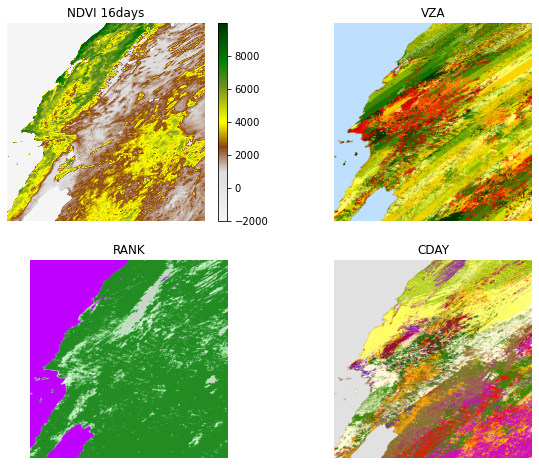

In [15]:
print("Plotting images... wait a couple of minutes")

#use a LUT color file for VZA and CDAY
#NDVILut=vip.LUT_load('NDVI_LUT2.dsr')
VZALut=vip.LUT_load('./ColorLUT/VZA_LUT.dsr')
CDAYLut=vip.LUT_load('./ColorLUT/CDAY65.dsr')

#create a custom LUT color for RANK
# GOOD  ->  green  (34,139,34)
# MARGINAL ->  light green ( 180,238,180)
# SNOW/ICE -> gray (207,207,207)
# CLOUD  -> while (255,255,255)
RANKLut=[[-1, 191, 0, 255],[RANK_GOOD, 34,139,34],[RANK_MARGINAL, 180,238,180],
         [RANK_SNOWICE,207,207,207],[RANK_CLOUDY,255,255,255]]



plt.figure(2)

# use NDVI custom color map
valueList  = [-0.6, -0.2, 0.,0.2, 0.5, 0.7, 1]  # Define the color nodes 
colorList = ["whitesmoke","gainsboro","saddlebrown","yellow","olivedrab","green","#003000"]  # Define the colors for each node 
cmapNDVI=vip.createColorMap([valueList,colorList],plt)


f, plot = plt.subplots(2, 2,figsize=(10,8))
print('Plotting NDVI')
#ImageLUT=vip.getImage_fromLUT(bandNDVI_compo,NDVILut)
im=plot[0,0].imshow(bandNDVI_compo, cmap=cmapNDVI, vmin=-2000)
plt.colorbar(im,ax=plot[0,0])
plot[0,0].set_title("NDVI 16days")
plot[0,0].axis('off')

print('Plotting VZA')
ImageLUT=vip.getImage_fromLUT(bandVZA_compo,VZALut)
im=plot[0,1].imshow(ImageLUT)
plot[0,1].set_title("VZA")
plot[0,1].axis('off')

print('Plotting RANK')
ImageLUT=vip.getImage_fromLUT(bandRANK_compo,RANKLut)
im=plot[1,0].imshow(ImageLUT)
plot[1,0].set_title("RANK")
plot[1,0].axis('off')

print('Plotting Composited DAY')
ImageLUT=vip.getImage_fromLUT(bandCDAY,CDAYLut)
im=plot[1,1].imshow(ImageLUT)
plot[1,1].set_title("CDAY")
plot[1,1].axis('off')

### * Save Composited results to HDF file

In [16]:
# Saving the Composted Results to a HDF file

# Create an HDF file

#set the output filename
FileName="MOD13A2.A2018001.Composited.hdf"
print("Saving file:",FileName)

#set the rows and columns
NUMROWS=bandNDVI_compo.shape[0]
NUMCOLS=bandNDVI_compo.shape[1]

#open a file handler for writting
hdf = SD(FileName, SDC.WRITE | SDC.CREATE)


# Create the NDVI holder 
sds = hdf.create("NDVI", SDC.INT16, (NUMROWS, NUMCOLS))
# Fill the dataset with a fill value
sds.setfillvalue(FILL_VI)
# Write data
sds.set(bandNDVI_compo)
# Close the dataset
sds.endaccess()


# Create the VZA holder 
sds = hdf.create("VZA", SDC.INT16, (NUMROWS, NUMCOLS))
# Fill the dataset with a fill value
sds.setfillvalue(-15000)
# Write data
sds.set(bandVZA_compo)
# Close the dataset
sds.endaccess()

# Create the RANK holder 
sds = hdf.create("RANK", SDC.INT8, (NUMROWS, NUMCOLS))
# Fill the dataset with a fill value
sds.setfillvalue(-1)
# Write data
sds.set(bandRANK_compo)
# Close the dataset
sds.endaccess()

# Create the CDAY holder 
sds = hdf.create("Compositing DAY", SDC.INT16, (NUMROWS, NUMCOLS))
# Fill the dataset with a fill value
sds.setfillvalue(-1)
# Write data
sds.set(bandCDAY)
# Close the dataset
sds.endaccess()

# Flush and close the HDF file
hdf.end()
print("done!")

Saving file: MOD13A2.A2018001.Composited.hdf
done!


## Homework (see presentation)

### a) Display daily NDVI and RANK image

In [8]:
#put here your code 



### b) Could you implement the code to do Compositing as the Avg of all good pixels?

In [9]:
#put your code here



### b) Could you design your own compositing approach (a method to pick the representative value for the period). 
###  Example: Minimize the blue band is one way. 

In [10]:
#put your code here


In [11]:
print("program ended.")

program ended.
